In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import plotly.graph_objects as go
import utm
import h3

repo_root = Path(os.getcwd()).parent

while not (repo_root / ".git").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

# set the pandas plotting backend to plotly
pd.options.plotting.backend = "plotly"

## Load Radar Data


In [3]:
## Read in the Data
from src.filtering import Filtering


df = pl.scan_parquet(
    "/Users/max/Library/CloudStorage/Box-Box/Radar-Data/new_format/1678*.parquet",
    rechunk=True,
)

# create the file paths
network_outline_file = repo_root / "geo_data" / "network_outline.geojson"
radar_locations_file = repo_root / "geo_data" / "radar_origins.json"

In [4]:
f = Filtering(
    radar_location_path=radar_locations_file,
    network_boundary_path=network_outline_file,
)

interest_df = (
    df.filter(pl.col("epoch_time").dt.day() == 14)
    .filter(pl.col("ip") == "10.160.7.146")
    .pipe(f.create_object_id)
    .pipe(f.crop_radius, radius=220)
    .pipe(f.crop_angle)
    # resample to 10 Hz
    # .pipe(f.resample, 100)
    # # remove objects that travel for very little time
    .pipe(f.filter_short_trajectories, minimum_distance_m=50, minimum_duration_s=2)
    .collect(streaming=True)
)

function: crop_radius took: 0.0002129077911376953 seconds
function: crop_angle took: 0.00045108795166015625 seconds
function: filter_short_trajectories took: 12.14891505241394 seconds


In [5]:
## Print the extent of data time
print(
    (
        (interest_df["epoch_time"].max() - interest_df["epoch_time"].min()).seconds
        / 60
        / 60
    ),
    "hours",
)

print(
    interest_df.shape[0] / 1e6,
)

23.99972222222222 hours
5.520801


In [6]:
# make the object ids a categorical
interest_df = interest_df.with_columns(
    pl.col("object_id").cast(pl.Categorical).cast(pl.Int32)
)


## Get the Extend of X & Y


In [7]:
# interest_df.select(["f32_positionX_m", "f32_positionY_m"]).describe()

## Sliding Window


In [8]:
import numpy as np
from skimage.feature.peak import peak_local_max

# create a grid of the data
x_bins = np.arange(
    interest_df["f32_positionX_m"].min(), interest_df["f32_positionX_m"].max(), 0.1
)
y_bins = np.arange(
    interest_df["f32_positionY_m"].min(), interest_df["f32_positionY_m"].max(), 0.1
)
hist, xedges, yedges = np.histogram2d(
    interest_df["f32_positionX_m"],
    interest_df["f32_positionY_m"],
    bins=[x_bins, y_bins],
)

# lognorm the histogram
# hist = np.log(hist + 1)



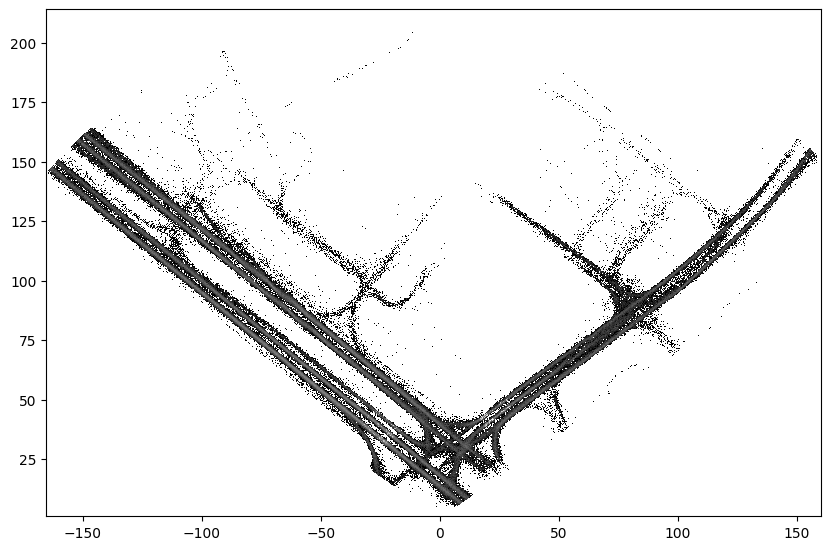

In [9]:
# plot the histogram
import matplotlib.pyplot as plt

# make 10, 10 figure
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(
    hist.T,
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    interpolation="none",
    norm="log",
    cmap="gray",
)

# make the axis square
ax.set_aspect("equal")

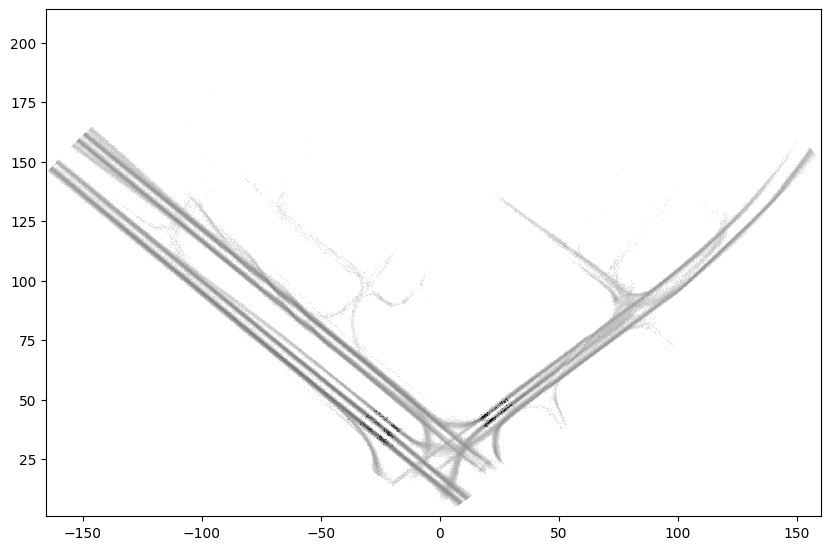

In [10]:
# # gaussian blur the histogram and shift it
from scipy.ndimage import (
    gaussian_filter,
    percentile_filter,
)

p_hist = percentile_filter(hist, 80, size=3)

# make 10, 10 figure
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(
    p_hist.T,
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    interpolation="none",
    norm="log",
    cmap="gray_r",
)

# make the axis square
ax.set_aspect("equal")

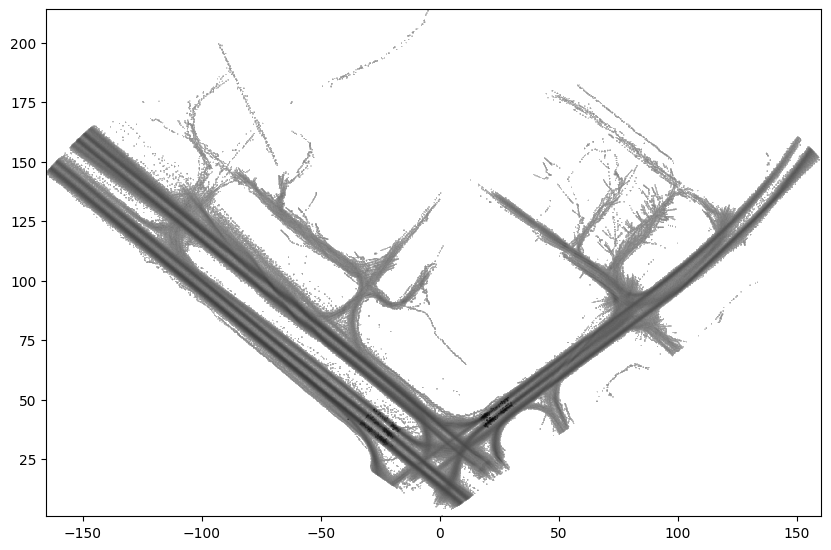

In [71]:
#  for smoothing
g_hist = gaussian_filter(p_hist, sigma=1.5, truncate=2.0)

# make 10, 10 figure
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(
    g_hist.T,
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    interpolation="none",
    norm="log",
    cmap="gray_r",
)

# make the axis square
ax.set_aspect("equal")

In [91]:
# find the peaks
peaks = peak_local_max(
    g_hist,
    min_distance=5,
    exclude_border=True,
    threshold_abs=np.quantile(g_hist, 0.95),
    p_norm=2
)

peak_list = list(
    map(
        list,
        zip(
            xedges[peaks[:, 0]],
            yedges[peaks[:, 1]],
        ),
    )
)

peak_points = np.array(list(peak_list))

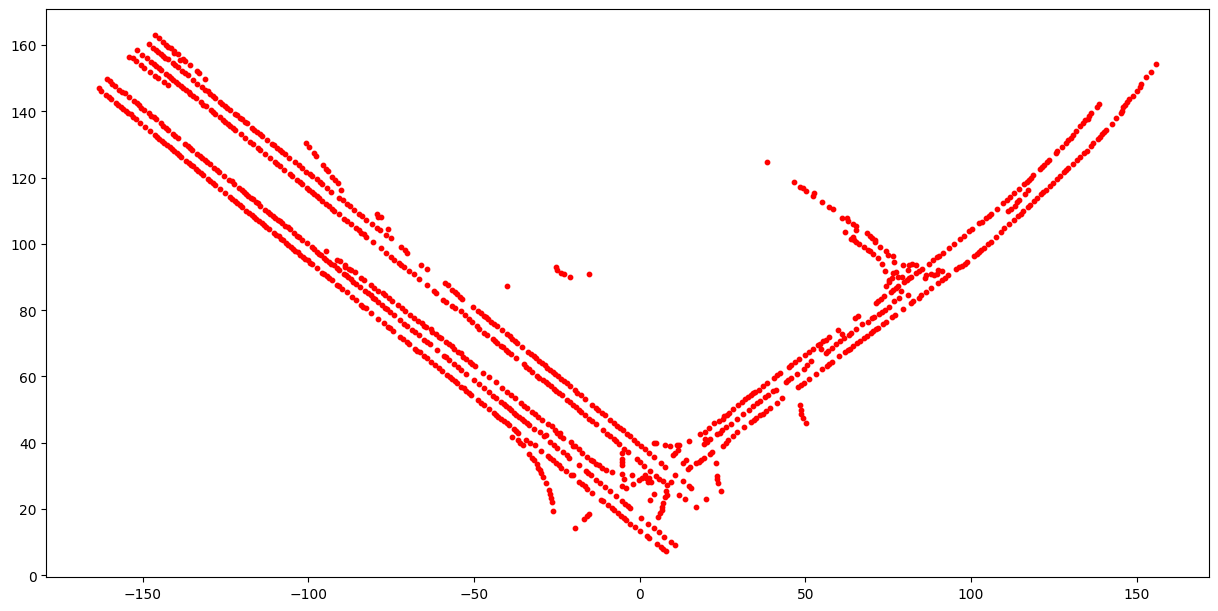

In [92]:
# show the peaks
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(peak_points[:, 0], peak_points[:, 1], c="r", s=10)

# set axis equal
ax.set_aspect("equal")

### Create a DataFrame Snapped to the Grid


In [14]:
from sklearn.neighbors import KDTree

points = interest_df.select(
    [
        "f32_positionX_m",
        "f32_positionY_m",
    ]
).to_numpy()

# get the peak points
peak_points = np.array(peak_list)

kd = KDTree(peak_points)
d, inds = kd.query(points, k=1)

In [15]:
# get the matching peak points
import numpy as np
import math

closest_peak_points = peak_points[inds.flatten()]

# merge back into the interest_df
snapped_df = (
    interest_df.with_columns(
        [
            pl.Series("closest_peak_x", closest_peak_points[:, 0]),
            pl.Series("closest_peak_y", closest_peak_points[:, 1]),
        ]
    )
    .with_columns(
        [
            pl.col("closest_peak_x").round(2).cast(pl.Float32).alias("closest_peak_x"),
            pl.col("closest_peak_y").round(2).cast(pl.Float32).alias("closest_peak_y"),
        ]
    )
    .groupby(["object_id", "closest_peak_x", "closest_peak_y"])
    .agg(
        pl.col("epoch_time").first().alias("epoch_time"),
    )
    .sort(["object_id", "epoch_time"])
    .with_columns(
        [
            pl.col("closest_peak_x")
            .shift(-1)
            .forward_fill()
            .over("object_id")
            .alias("next_x"),
            pl.col("closest_peak_y")
            .shift(-1)
            .forward_fill()
            .over("object_id")
            .alias("next_y"),
        ]
    )
    .with_columns(
        [
            # calculate the y_diff
            (pl.col("next_y") - pl.col("closest_peak_y")).alias("y_diff"),
            # calculate the x_diff
            (pl.col("next_x") - pl.col("closest_peak_x")).alias("x_diff"),
        ]
    )
)

In [16]:
ANGLE_THRESHOLD = 35

vals = snapped_df.select(["y_diff", "x_diff"]).to_numpy()
angle = np.rad2deg(np.arctan2(vals[:, 0], vals[:, 1]))

snapped_df = (
    snapped_df.with_columns(
        [
            pl.Series("angle", angle),
        ]
    )
    .with_columns(
        [
            pl.col("angle")
            .shift(-1)
            .forward_fill()
            .over("object_id")
            .alias("next_angle"),
            # pl.col("angle").shift(1).backward_fill().over("object_id").alias("last_angle"),
        ]
    )
    .with_columns(
        [
            # calculate the angle difference
            ((pl.col("next_angle") - pl.col("angle")) + 180 % 360 - 180).alias(
                "angle_diff"
            ),
        ]
    )
)
# # filter any angle diffs that are greater than 35 degrees
snapped_df = snapped_df.filter((pl.col("angle_diff").abs() < ANGLE_THRESHOLD))

# # # reshift the next_x and next_y
# snapped_df = (
#     snapped_df
#     .with_columns(
#         [
#             pl.col("closest_peak_x").shift(-1).forward_fill().over("object_id").alias("next_x"),
#             pl.col("closest_peak_y").shift(-1).forward_fill().over("object_id").alias("next_y"),
#         ]
#     )
# )

### Vehicle Clustering


In [17]:
# vehicles = (
#     snapped_df.with_columns(
#         pl.concat_list(["closest_peak_x", "closest_peak_y"]).alias("vector")
#     )
#     .groupby("object_id")
#     .agg(["vector"])
#     .select(["object_id", "vector"])
#     .to_pandas()
# )

In [18]:
# import numpy as np
# from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
# from functools import partial
# from tqdm import tqdm
# from src.distance import calculate_distance
# import itertools


# def parallel_distance_matrix(vehicles_, vehicle_ids, common_h3_dict):
#     distance_matrix = np.zeros((len(vehicles_), len(vehicles_)))

#     with ProcessPoolExecutor(max_workers=8) as executor:
#         partial_func = partial(calculate_distance, vehicles_=vehicles_)

#         # create a iterator
#         indexes = []
#         passes = set()
#         for i in range(len(vehicles_)):
#             indexes.append([(i, i, 0)])
#             for j in range(i + 1, len(vehicles_)):
#                 # v1 = vehicle_ids[i]
#                 # v2 = vehicle_ids[j]


#                 # v2 = vehicle_ids[j]
#                 # if (
#                 #     {v1, v2} not in passes
#                 #     and v1 in common_h3_dict
#                 #     and v2 in common_h3_dict[v1]
#                 # ):
#                 indexes[-1].append((i, j, 0))
#                 # else:
#                 #     passes.add((i, j))
#                 #     indexes[-1].append((i, j, np.inf))

#         # return indexes

#         results = list(
#             tqdm(
#                 executor.map(partial_func, indexes),
#                 total=len(vehicles_),
#                 desc="Calculating distances",
#             )
#         )

#     # # Sort the results based on the index
#     results.sort(key=lambda x: x[0])

#     # # Construct the distance matrix
#     for i, row in results:
#         distance_matrix[i] = row

#     return distance_matrix


# distance_matrix = parallel_distance_matrix(
#     vehicles["vector"].apply(lambda x: np.array(x.tolist())).to_list(),
#     vehicles["object_id"].to_list(),
#     {},
# )


In [19]:
# # mirror the matrix on the diagonal
# distance_matrix = (
#     distance_matrix + distance_matrix.T - np.diag(distance_matrix.diagonal())
# )

# # fill the inf values with the max value (not )
# distance_matrix[distance_matrix == np.inf] = distance_matrix[
#     distance_matrix != np.inf
# ].max()


In [20]:
# from sklearn.cluster import DBSCAN

# cl = DBSCAN(eps=10, min_samples=2, metric="precomputed")
# cl.fit(distance_matrix)

# print(np.unique(cl.labels_))


In [21]:
# # plot the clusters
# import plotly.graph_objects as go
# import plotly.express as px
# from scipy.spatial import ConvexHull
# import alphashape

# fig = go.Figure()

# label_dfs = {}

# # create a set of colors for the clusters
# colors = (
#     px.colors.qualitative.D3_r
#     + px.colors.qualitative.Plotly_r
#     + px.colors.qualitative.Alphabet_r
#     + px.colors.qualitative.Dark24_r
# )  # + px.colors.qualitative.Dark24_r + px.colors.qualitative.Pastel_r + px.colors.qualitative.Prism_r + px.colors.qualitative.Set1_r + px.colors.qualitative.Set2_r + px.colors.qualitative.Set3_r

# for j, label in enumerate(np.unique(cl.labels_)):
#     if label == -1:
#         continue

#     # get the points in the cluster
#     points = []
#     vehicles_ = []
#     for i in np.where(cl.labels_ == label)[0]:
#         # points.append(vehicles_[i])
#         vehicles_.append(vehicles["object_id"].iloc[i])

#     label_dfs[label] = vehicles_

#     # get the points in the cluster
#     _df = snapped_df.filter(pl.col("object_id").is_in(vehicles_))
#     _df = _df.sample(
#         min(1000, len(_df)),
#     )

#     fig.add_trace(
#         go.Scatter(
#             x=_df["closest_peak_x"],
#             y=_df["closest_peak_y"],
#             mode="markers",
#             name=f"cluster {label}",
#             # fill="toself",
#             # fillcolor=color,
#             # line_color=color,
#         )
#     )

# # make the plot square
# fig.update_layout(
#     width=800,
#     height=800,
#     autosize=False,
#     showlegend=True,
#     xaxis=dict(
#         scaleanchor="y",
#         scaleratio=1,
#     ),
# )

# # make figure span the whole figure
# fig.update_layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0,
#         pad=0,
#     )
# )

# fig.show()
# # fig.show(renderer="png")


### Create a DataFrame with the Grid


In [22]:
nn = kd.query_radius(peak_points, r=30)
matches = np.array(
    [[peak_list[i], peak_list[j]] for i, js in enumerate(nn) for j in js]
).round(2)

peak_df = pl.DataFrame(
    {
        "pairs": matches,
        "start": matches[:, 0],
        "end": matches[:, 1],
        "start_x": matches[:, 0, 0],
        "start_y": matches[:, 0, 1],
        "end_x": matches[:, 1, 0],
        "end_y": matches[:, 1, 1],
    }
).with_columns([pl.col(pl.FLOAT_DTYPES).cast(pl.Float32)])

In [23]:
peak_df = (
    peak_df.lazy()
    .join(
        snapped_df.select(
            ["closest_peak_x", "closest_peak_y", "next_x", "next_y", "object_id"]
        ).lazy(),
        left_on=["start_x", "start_y", "end_x", "end_y"],
        right_on=["closest_peak_x", "closest_peak_y", "next_x", "next_y"],
        how="inner",
        suffix="_start",
    )
    .groupby(["start_x", "start_y", "end_x", "end_y"])
    .agg(
        [
            pl.col("object_id").count().alias("count"),
            pl.col("start").first().alias("start"),
            pl.col("end").first().alias("end"),
        ]
    )
    .collect()
)

In [93]:
peak_df_pd = peak_df.to_pandas()

# turn the start and end into tuples
peak_df_pd[["start", "end"]] = peak_df_pd[["start", "end"]].applymap(
    lambda x: tuple(np.round(x, 2).tolist())
)


median_count = peak_df_pd["count"].quantile(0.6)

peak_df_pd = peak_df_pd.loc[peak_df_pd["count"] > median_count]

In [97]:
t = peak_df_pd.pivot(
    index="start", columns="end", values="count"
).fillna(0)

In [104]:
v = t.to_dict()

### Make a Graph


In [25]:
import networkx as nx

G = nx.from_pandas_edgelist(
    peak_df_pd, source="start", target="end", edge_attr="count", create_using=nx.DiGraph
)


def update_weights(G):
    # add a weight to the node as the sum of incoming edges
    for node in G.nodes:
        G.nodes[node]["weight"] = sum(n[-1] for n in G.in_edges(node, data="count"))
        if G.nodes[node]["weight"] == 0:
            G.nodes[node]["weight"] = sum(
                n[-1] for n in G.out_edges(node, data="count")
            )
    return G


def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


def add_distance_weights(G):
    for edge in G.edges:
        G.edges[edge]["distance"] = distance(edge[0], edge[1])

    return G


G = add_distance_weights(G)
G = update_weights(G)

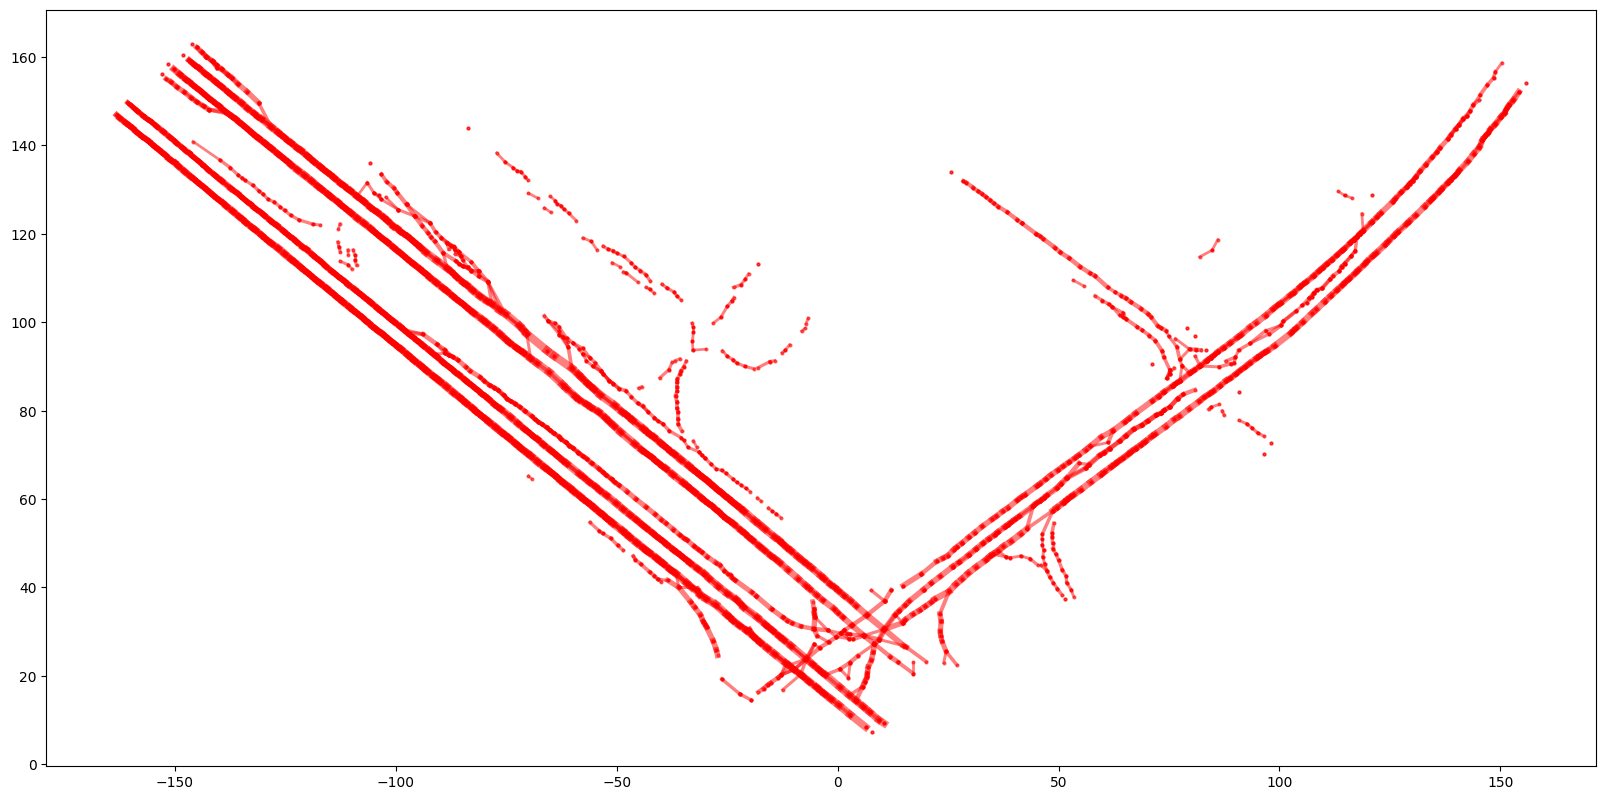

In [26]:
def plot_graph(G):
    fig, ax = plt.subplots(figsize=(10, 10))

    for node in G.nodes:
        # plot the connections as lines
        for edge in G.edges(node):
            # plot with the weight as the width, and a arrow in the direction of the edge
            ax.plot(
                [edge[0][0], edge[1][0]],
                [edge[0][1], edge[1][1]],
                c="r",
                linewidth=max(G.edges[edge]["count"] ** (1 / 5), 1),
                alpha=0.5,
                # add an arrow to the end of the line
                marker="o",
                markersize=2,
                markerfacecolor="r",
                markeredgecolor="r",
            )

    # make the plot square
    ax.set_aspect("equal")

    return fig, ax


f, ax = plot_graph(G)

f.set_size_inches(20, 20)

### Drop BiDirectional Edges


In [27]:
# drop bidirectional edges
remove_edges = set()

for edge in G.edges:
    if G.has_edge(edge[1], edge[0]):
        if G.edges[edge]["count"] > G.edges[(edge[1], edge[0])]["count"]:
            # G.remove_edge(edge[1], edge[0])
            remove_edges.add((edge[1], edge[0]))
        else:
            # G.remove_edge(edge[0], edge[1])
            remove_edges.add((edge[0], edge[1]))

G.remove_edges_from(remove_edges)


### Drop Edges with Low Probability Compared to their From Node


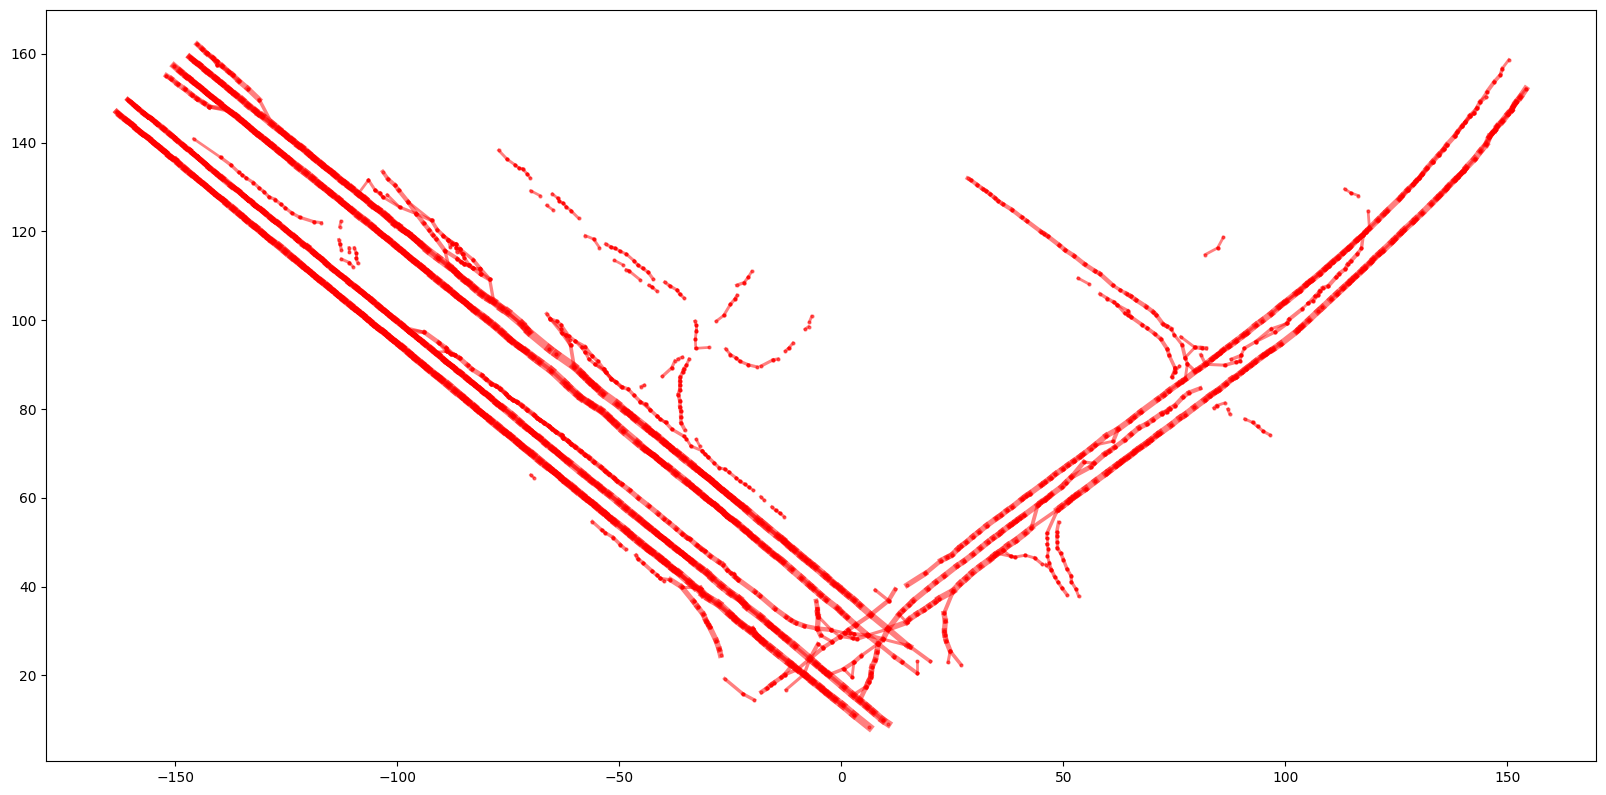

In [28]:
nodes = list(G.nodes)

for n in nodes:
    # get out edges
    out_edges = list(G.out_edges(n, data="count"))

    # get the weight of the node
    weight = G.nodes[n]["weight"]

    for e in out_edges:
        if e[-1] < (weight * 0.01):
            G.remove_edge(e[0], e[1])

    update_weights(G)


fig, ax = plot_graph(G)

# update the size of fig
fig.set_size_inches(20, 20)

### Prune Skip Connections

ie A->B-C instead of A->C


In [29]:
# # get a list of edges sorted by length
# sorted_edges = sorted(
#     G.edges(data="count"), key=lambda x: distance(x[0], x[1]), reverse=True
# )

# i = 0
# while len(sorted_edges):
#     # get the longest edge
#     u, v, w = sorted_edges.pop(0)
#     if paths := list(nx.all_simple_paths(G, u, v, cutoff=2)):
#         # don't remove the u,v edge if there is a path between u and v
#         for p in paths:
#             if len(p) > 2 and all(
#                 G.has_edge(p[i], p[i + 1]) for i in range(len(p) - 1)
#             ):
#                 for i in range(len(p) - 2):
#                     # get the weight of the edge
#                     weight = G.edges[p[i], p[i + 1]]["count"]
#                     # add the weight to the longer edge
#                     G.edges[u, v]["count"] += weight
#                     G.remove_edge(p[i], p[i + 1])
#                     # remove the shorter edge from the list of edges
#                     sorted_edges = [
#                         e for e in sorted_edges if e[0] != p[i] or e[1] != p[i + 1]
#                     ]

#                 # remove the middle node, if it has no out edges
#                 if not len(list(G.out_edges(p[1]))):
#                     G.remove_node(p[1])


# plot_graph(G)

### Drop Edges With High Angle


In [30]:
# get the angle between the two edges
def get_angle(edge1, edge2):
    # Calculate the direction vectors for the lines
    direction_vector1 = edge1[1] - edge1[0]
    direction_vector2 = edge2[0] - edge2[1]
    v1_u = direction_vector1 / np.linalg.norm(direction_vector1)
    v2_u = direction_vector2 / np.linalg.norm(direction_vector2)
    dot = np.dot(v1_u, v2_u)
    det = np.linalg.det([v1_u, v2_u])
    angle = np.arctan2(det, dot)
    return abs(np.rad2deg(angle))


### Find Disconnected Subgraphs


In [108]:
components = list(nx.weakly_connected_components(G))
print([len(c) for c in components])


new_G = G.subgraph(_c for c in components[:3] for _c in c)

[1000, 172, 18, 15, 11, 17, 1, 1, 1, 10, 1, 1, 1, 1, 12, 1, 1, 1, 1, 1, 1]


In [113]:
nx.all_simple_paths(new_G, (0, 0), (0, 0), cutoff=10)

KeyboardInterrupt: 

In [31]:
UG = G.to_undirected()

# get the connected components
components = list(nx.connected_components(UG))

In [32]:
# print the number of components
print([len(c) for c in components])

# prune subgraphs that are too small ( < 10 nodes)
prunes = [c for c in components if len(c) < 10]

for p in prunes:
    for n in p:
        in_edges = list(G.in_edges(n))
        for in_edge in in_edges:
            G.remove_edge(*in_edge)
        
        out_edges = list(G.out_edges(n))
        for out_edge in out_edges:
            G.remove_edge(*out_edge)

        if n in G.nodes:
            G.remove_node(n)
        

        # remove any edges that are now dangling

[1023, 173, 18, 15, 5, 7, 4, 2, 1, 5, 17, 2, 7, 10, 2, 12, 1, 1, 2, 2, 3, 3, 2, 1, 3, 2, 6, 1, 1, 1, 1, 2, 5, 4, 1, 3, 6, 3, 3, 2, 3, 1, 6, 1, 1, 3, 3, 1, 1, 4, 2, 2, 3, 2, 2, 3, 2, 1, 1, 1, 1, 3, 1]


### Cleanup the Ends


In [34]:
def del_node(G, node):
    if G.has_node(node):
        G.remove_node(node)
        return True
    return False


def del_edge(G, edge):
    if G.has_edge(*edge):
        G.remove_edge(*edge)
        return True
    return False


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

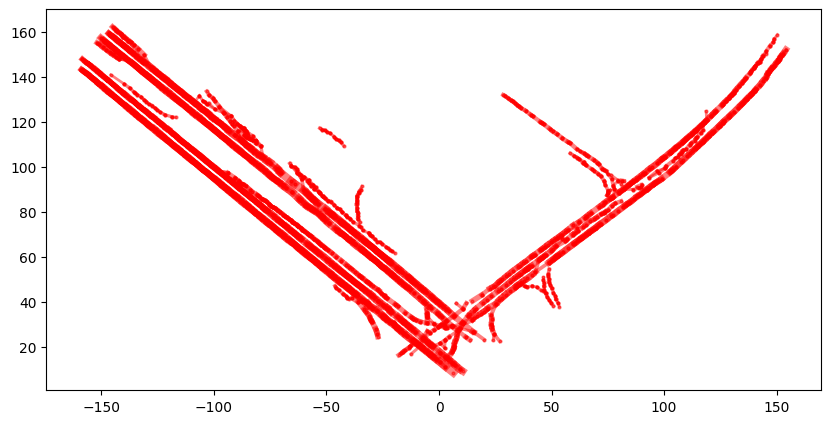

In [35]:
birth_nodes = []
num_birth_nodes = len([n for n in G.nodes if G.in_degree(n) == 0])

for _ in range(2):
    #
    nodes = list(G.nodes(data=True))
    nodes.sort(key=lambda x: x[1]["weight"], reverse=True)
    for n in nodes:
        if G.in_degree(n[0]) == 0:
            # this is the end of the line
            # get the in edges
            out_edges = list(G.out_edges(n[0]))
            if len(out_edges) == 1:
                # if there is only one in edge, add it to the list
                birth_nodes.append(n)

            elif len(out_edges) > 1:
                # remove the node
                del_node(G, n)
                for edge in out_edges:
                    # remove the edge
                    del_edge(G, edge)

    num_birth_nodes = len([n for n in G.nodes if G.in_degree(n) == 0])

plot_graph(G)


### Find Start and End Nodes

Start Nodes should have in degree == 0

- If their out degree is > 1, then remove the node and the outgoing connections

End Nodes should have out degree == 0

- If their in degree is > 1, then remove the node and the incoming connections


In [36]:
birth_death_df = (
    snapped_df.groupby(
        "object_id",
    )
    .agg(
        [
            pl.col("closest_peak_x").first().alias("birth_x"),
            pl.col("closest_peak_y").first().alias("birth_y"),
            pl.col("closest_peak_x").last().alias("death_x"),
            pl.col("closest_peak_y").last().alias("death_y"),
        ]
    )
    .with_columns(
        [
            pl.concat_list(
                [
                    pl.col("birth_x"),
                    pl.col("birth_y"),
                ]
            ).alias("birth"),
            pl.concat_list(
                [
                    pl.col("death_x"),
                    pl.col("death_y"),
                ]
            ).alias("death"),
        ]
    )
    .to_pandas()
)


birth_death_df[["birth", "death"]] = birth_death_df[["birth", "death"]].applymap(
    lambda x: tuple(round(v, 2) for v in x.tolist())
)

# get a list of all nodes that exist in Graph
valid_nodes = set(G.nodes)


In [37]:
death_counts = (
    birth_death_df.loc[birth_death_df["death"].isin(valid_nodes)]
    .groupby("death")["object_id"]
    .count()
    .copy()
    .reset_index()
    .sort_values("object_id", ascending=False)
)

birth_counts = (
    birth_death_df.loc[birth_death_df["birth"].isin(valid_nodes)]
    .groupby("birth")["object_id"]
    .count()
    .copy()
    .reset_index()
    .sort_values("object_id", ascending=False)
)

#### Death Nodes


In [38]:
def subtract_angles_properly(a, b):
    return (a - b) + 180 % 360 - 180

In [39]:
import itertools
import contextlib

death_points = death_counts.query(f"object_id > {death_counts['object_id'].mean()}")["death"].to_list()
pairs = list(itertools.product(death_points, death_points))

valid_deaths = {}

for p1, p2 in pairs:
    if p1 == p2:
        continue

    if p1 not in valid_deaths:
        valid_deaths[p1] = 1

    path = None
    with contextlib.suppress(nx.NetworkXNoPath):
        path = nx.shortest_path(G, p1, p2)
        # calulate the angles, if there is a large angle, place a break there
        max_angle = 0
        for i in range(len(path) - 2):
            angle = get_angle(
                np.array([path[i], path[i + 1]]), np.array([path[i + 1], path[i + 2]])
            )
            max_angle = max(max_angle, abs(subtract_angles_properly(angle, 180)))
            break

        # if max_angle > 20:
        valid_deaths[p1] *= 0
    
    # if path is None:
    #     valid_deaths[p2] = 1



valid_deaths = [v for v, l in valid_deaths.items() if l > 0]

# also add all nodes that have no in edges
valid_deaths.extend([n for n in G.nodes if G.out_degree(n) == 0])

valid_births = list(set(valid_deaths))

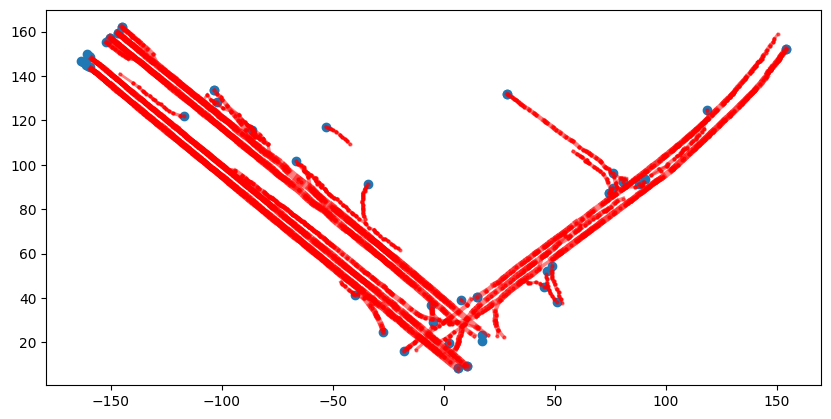

In [40]:
f, ax = plot_graph(G)

# plot the death nodes
valid_deaths_p = np.array(list(valid_deaths))

ax.scatter(
    valid_deaths_p[:, 0],
    valid_deaths_p[:, 1],
)


#### Birth Nodes


In [41]:
import itertools

birth_points = birth_counts.query(f"object_id > {birth_counts['object_id'].mean()}")["birth"].to_list()
pairs = list(itertools.product(birth_points, birth_points))
valid_births = {}

for p1, p2 in pairs:
    if p1 == p2:
        continue

    if p2 not in valid_births:
        valid_births[p2] = 1

    with contextlib.suppress(nx.NetworkXNoPath):
        path = nx.shortest_path(G, p1, p2)
        # calulate the angles, if there is a large angle, place a break there
        max_angle = 0
        for i in range(len(path) - 2):
            angle = get_angle(
                np.array([path[i], path[i + 1]]), np.array([path[i + 1], path[i + 2]])
            )
            max_angle = max(max_angle, abs(subtract_angles_properly(angle, 180)))
            break

        # if angle < 35:
        valid_births[p2] *= 0

valid_births = [v for v, l in valid_births.items() if l > 0]


# also add all nodes that have no in edges
valid_births.extend([n for n in G.nodes if G.in_degree(n) == 0])

valid_births = list(set(valid_births))

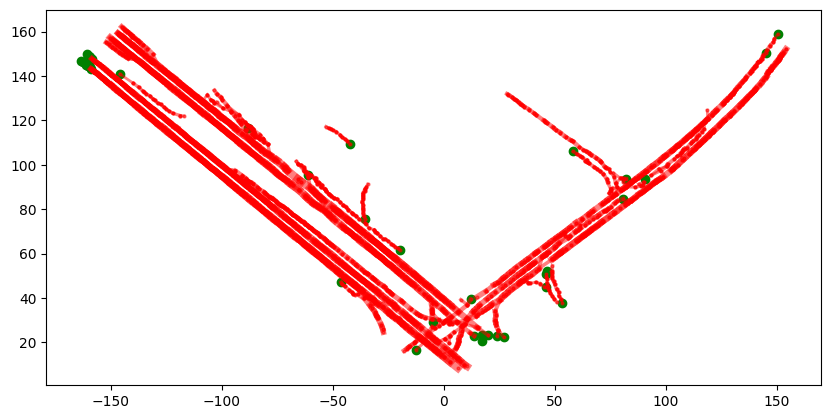

In [42]:
f, ax = plot_graph(G)

# plot the death nodes
valid_births_p = np.array(list(valid_births))

ax.scatter(valid_births_p[:, 0], valid_births_p[:, 1], c="g")

### Find Unique Paths from Birth Nodes to Death Nodes


In [47]:
### Calculate the path between the birth and death nodes
def get_path(G, birth_node, death_node):
    # get the path
    path = nx.dijkstra_path(G, birth_node, death_node, weight="distance")

    # split the path into segments where the angle between the segments is greater than 20 degrees
    path_segments = [[path[0]]]
    for i in range(len(path) - 2):
        angle = get_angle(
            np.array([path[i], path[i + 1]]), np.array([path[i + 1], path[i + 2]])
        )
        angle = abs(subtract_angles_properly(angle, 180))
        # if angle > 90:
        #     continue
        if angle < 45:
            path_segments[-1].append(path[i + 1])
        else:
            # skip the offending node
            path_segments.append([])

    for p in path_segments:
        if len(p):
            yield (
                p,
                sum(G.edges[e]["distance"] for e in zip(p[:-1], p[1:])),
                min(G.nodes[n]["weight"] for n in p),
            )


In [48]:
import contextlib

paths = []


for b in valid_births:
    for d in valid_deaths:
        with contextlib.suppress(nx.NetworkXNoPath):
            paths.extend(
                (path, path_length, path_weight)
                for path, path_length, path_weight in get_path(G, b, d)
            )

# prune paths that are too short
paths = [p for p in paths if len(p[0]) > 10]


In [50]:
# sourcery skip: invert-any-all, use-any
from collections import deque

paths = sorted(paths, key=lambda x: x[2], reverse=True)


cleaned_paths = []

for i in range(len(paths)):
    for j in range(len(paths)):
        if i == j:
            continue
        # first test if they have the same end points
        if len(set(paths[j][0]).intersection(set(paths[i][0]))) > 2:
            # walk backwards until the paths diverge
            # snip the path where it also intersects i
            new_path = deque()
            for k, p in enumerate(paths[j][0]):
                if p not in paths[i][0]:
                    new_path.append((k, p))

            if len(new_path) == 0:
                paths[j] = ([], 0, 0)
                continue

            # find contigious segments of no overlap
            contigous_paths = [[]]
            p1 = new_path.popleft()
            while len(new_path) > 0:
                p2 = new_path.popleft()
                if ((p2[0] - p1[0]) > 2) and len(contigous_paths[-1]):
                    # this is a broken segment
                    contigous_paths.append([])
                else:
                    # this is a contigious segment
                    contigous_paths[-1].append(p1[1])

                p1 = p2


            count = 0
            # sort the paths by length
            contigous_paths = sorted(contigous_paths, key=lambda x: len(x), reverse=True)
            for path in contigous_paths:
                if len(path) > 1:
                    # check if this path is valid
                    valid = True
                    for k in range(len(path) - 1):
                        if not G.has_edge(path[k], path[k + 1]):
                            valid = False
                            break

                    if valid:
                        count += 1
                        paths[j] = (
                            path ,
                            sum(G.edges[e]["distance"] for e in zip(path[:-1], path[1:])),
                            min(G.nodes[n]["weight"] for n in path),
                        )
                        break
                        # break

            if count < 1:
                paths[j] = ([], 0, 0)        
        # else:
        #     # cleaned_paths.append(paths[i])
        

paths = [p for p in paths if len(p[0]) > 2]

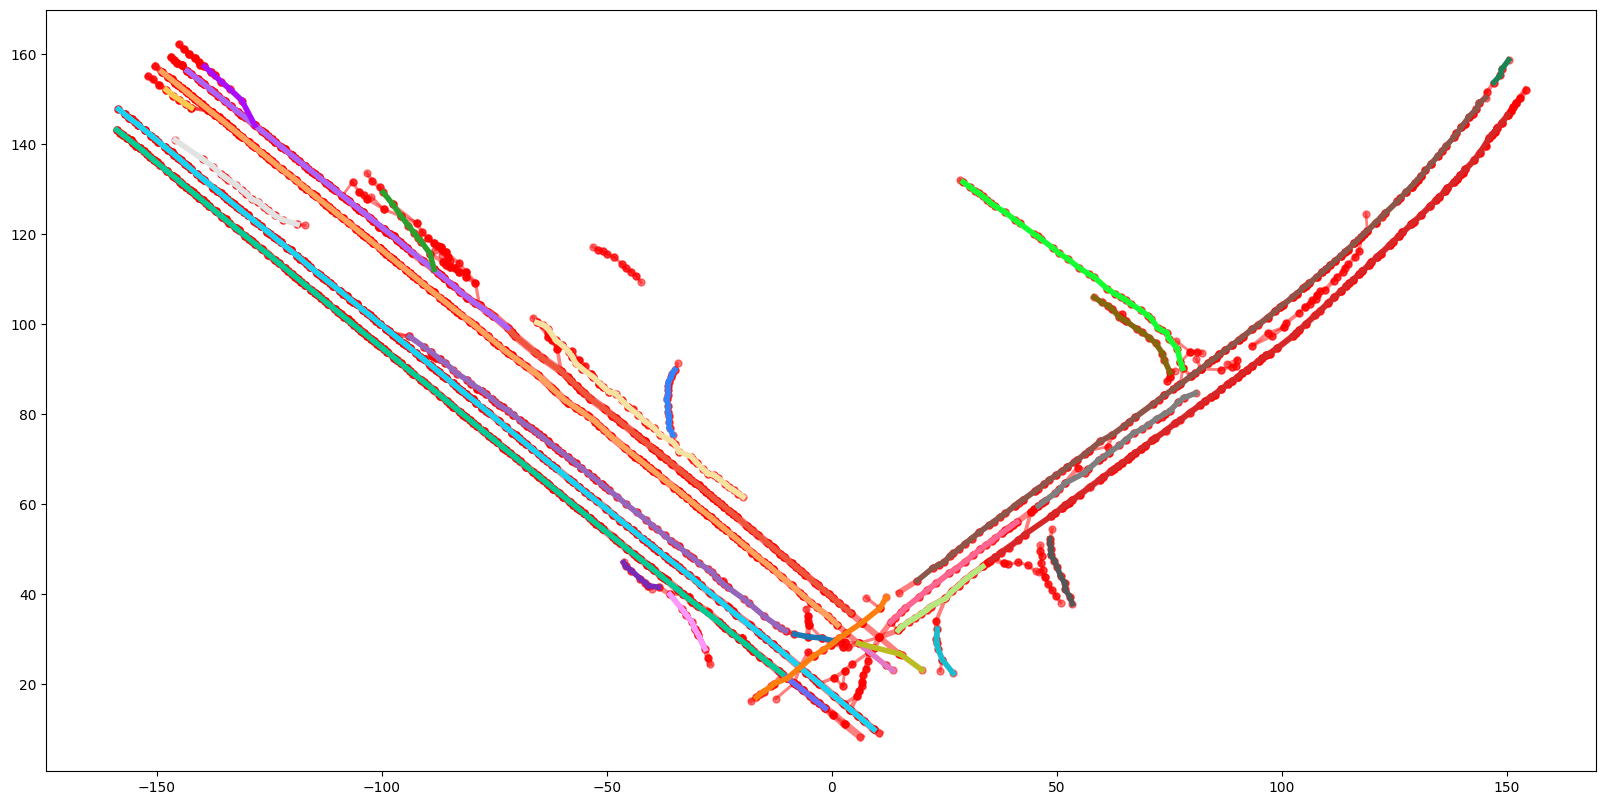

In [51]:
# plot the nodes on a map
import matplotlib.pyplot as plt
import plotly.express as px

fig, ax = plt.subplots(figsize=(20, 20))

for node in G.nodes:
    # plot the connections as lines
    for edge in G.edges(node):
        # plot with the weight as the width, and a arrow in the direction of the edge
        ax.plot(
            [edge[0][0], edge[1][0]],
            [edge[0][1], edge[1][1]],
            c="r",
            linewidth=max(G.edges[edge]["count"] ** (1 / 5), 1),
            alpha=0.5,
            # add an arrow to the end of the line
            marker="o",
            markersize=5,
            markerfacecolor="r",
            markeredgecolor="r",
        )


# plot the paths as lines
for j, path in enumerate(paths):
    for i in range(len(path[0]) - 1):
        ax.plot(
            [path[0][i][0], path[0][i + 1][0]],
            [path[0][i][1], path[0][i + 1][1]],
            c=(
                px.colors.qualitative.Plotly
                + px.colors.qualitative.D3
                + px.colors.qualitative.Alphabet
            )[j],
            linewidth=4,
            alpha=1,
        )

# make the axis equal
ax.set_aspect("equal")